## Burger's Equation
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in [-1,1],\ t\in(0,1] 
\end{equation}
We set $\nu=0.1/\pi$ and consider the periodic boundary condition here, i.e.:
$$
u(-1, t) = u(1, t),\quad t\in(0,1]
$$
The initial condition is $u(x,t=0)=a(x)$. Our goal is to learn a neural operator to predict the solution $u$ at $t=1$ given an initial condition $a(x)$, i.e.:
$$
\mathcal{G}: a(x) \rightarrow u(x,t=1)
$$

## (2) The Physics-informed DeepOnet

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 10086 
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Burgers_1d'
tag = 'tanhBeta64'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/Burgers_1d/viscid_train.mat', 'r')
data_test = h5py.File('../../Problems/Burgers_1d/viscid_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
######################################
from Utils.utils import *
n_train, n_test = 1000, 50
def get_data(data, ndata, dtype, n0=0):
    # Data is of the shape (number of samples = 1000, grid size = 29*29)
    a = np2tensor(np.array(data["u0"][...,n0:n0+ndata]).T, dtype)
    u = np2tensor(np.array(data["u_sol"][...,n0:n0+ndata]).T, dtype)
    uT = u[:,-1,:]
    #
    x_mesh = np.array(data['x_mesh']).T
    t_mesh = np.array(data['t_mesh']).T
    X, T = np.meshgrid(x_mesh, t_mesh)
    mesh = np2tensor(np.vstack([X.ravel(), T.ravel()]).T, dtype)
    grid_xt = mesh.reshape(-1, 2)
    #
    x = np2tensor(x_mesh).reshape(1, -1, 1).repeat(ndata,1,1)
    a = a.reshape(ndata, -1, 1)
    u = u.reshape(ndata, -1, 1)
    uT = uT.reshape(ndata, -1, 1)
    
    return a, u, uT, x, grid_xt
#
a_train, u_train, uT_train, x_train, gridxt_train = get_data(data_train, n_train, dtype)
a_test, u_test, uT_test, x_test, gridxt_test = get_data(data_test, n_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of uT_train:', uT_train.shape)
print('The shape of gridxt_train:', gridxt_train.shape)
#
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of uT_train:', uT_test.shape)
print('The shape of gridxt_test:', gridxt_test.shape)
######################################
# Generate training data
######################################
from Utils.GenPoints_Time import Point1D
pointGen = Point1D(x_lb=[-1.], x_ub=[1.], dataType=dtype, random_seed=random_seed)
#### Particles (centers of CSRBFs)
xc_train, tc_train, R_train = pointGen.weight_centers(
    n_center=1, nt=5000, Rmax=1e-4, Rmin=1e-4, method='hypercube')
####  (initial points)
xt_init = pointGen.init_point(num_sample=a_test.shape[1], t_stamp=[0.], method='mesh')
####  (initial points)
xt_end = pointGen.init_point(num_sample=uT_test.shape[1], t_stamp=[1.], method='mesh')
####  (boundary points)
xt_lb, xt_ub = pointGen.boundary_point(num_sample=500)

<KeysViewHDF5 ['t_mesh', 'u0', 'u_sol', 'x_mesh']>
<KeysViewHDF5 ['t_mesh', 'u0', 'u_sol', 'x_mesh']>
The shape of x_train: torch.Size([1000, 128, 1])
The shape of a_train: torch.Size([1000, 128, 1])
The shape of u_train: torch.Size([1000, 12928, 1])
The shape of uT_train: torch.Size([1000, 128, 1])
The shape of gridxt_train: torch.Size([12928, 2])
The shape of x_test: torch.Size([50, 128, 1])
The shape of a_test: torch.Size([50, 128, 1])
The shape of u_test: torch.Size([50, 12928, 1])
The shape of uT_train: torch.Size([50, 128, 1])
The shape of gridxt_test: torch.Size([12928, 2])


### (2.2) Define the loss class

In [2]:
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=1, n_mesh_or_grid=10, dataType=dtype).get_testFun()
print('The shape of int_grid', int_grid.shape, 'The shape of phi:', phi.shape)

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, xt):
        x= xt[...,0:1]
        u = u * torch.sin(np.pi*x/2. + np.pi/2.)
        return u

##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']
        self.mollifer = mollifer()
        ######################## 
        self.n_grid = int_grid.shape[0]
        self.int_grid = int_grid.to(self.device)
        
    def Loss_pde(self, a_batch, w_pde, nc=100, lamda=0.1/torch.pi):
        ''' PDE loss'''
        if w_pde>0.:
            n_batch = a_batch.shape[0]
            # ################################## 
            xc, tc, R = pointGen.weight_centers(n_center=1, nt=nc, Rmax=1e-4, Rmin=1e-4, method='hypercube')
            xc, tc, R = xc.to(self.device), tc.to(self.device), R.to(self.device)
            #
            x = (self.int_grid * R + xc).reshape(-1, 1)
            t = tc.repeat(1, self.n_grid, 1).reshape(-1, 1)
            #
            x = Variable(x.repeat((n_batch,1,1)), requires_grad=True) 
            t = Variable(t.repeat((n_batch,1,1)), requires_grad=True)  
            xt = torch.cat([x,t], dim=-1)
            ##########################################
            u = self.model_u(xt, a_batch)
            u = self.mollifer(u, xt)
            du = grad(inputs=xt, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            dux, dut = du[...,0:1], du[...,1:2]
            #
            ddux = grad(inputs=xt, outputs=dux, grad_outputs=torch.ones_like(dux), create_graph=True)[0]
            duxx = ddux[...,0:1]
            ########################################### strong form
            res = dut + u * dux - lamda * duxx

            return self.solver.getLoss(res, torch.zeros_like(res))
        else:
            return torch.tensor(0.)
        
        return loss

    def Loss_data(self, x, a, u, w_data):
        n_batch = a.shape[0]
        ############### The initial condition
        xt = xt_init.repeat(n_batch, 1, 1).to(self.device)
        u_init = self.model_u(xt, a)
        u_init = self.mollifer(u_init, xt)
        #
        loss_init = self.solver.getLoss(u_init, a)
        
        return loss_init
        
    def Error(self, x, a, u):
        n_batch = a.shape[0]
        ##################
        xt = gridxt_test.repeat(n_batch, 1, 1).to(self.device)
        u_all = self.model_u(xt, a)
        u_all = self.mollifer(u_all, xt)
        #
        error = self.solver.getError(u_all, u)

        return error
        

######################################
# Setups of the model
######################################
from Solvers.PIDeepONet import PIDeepONet
solver = PIDeepONet.Solver(device=device, dtype=dtype)
netType = 'DeepONetBatch'
# ####################################### 
from Networks.FCNet import FCNet
from Networks.EncoderNet import EncoderFCNet
#
class BranchNet(nn.Module):
    def __init__(self, layers_beta, act_beta, act_fc, dtype=None):
        super(BranchNet, self).__init__()
        #
        self.beta_net = EncoderFCNet(layers_beta, act_beta, dtype=dtype)
        self.fc_net = FCNet([layers_beta[-1]]+[80]*7, act_fc, dtype=dtype)
        
    def forward(self, x):
        '''
        Input:
            x: size(?, ny*nx, in_channel)
        Return:
            output: size(?, out_size)
        '''
        # size(n_batch, ny*nx, in_channel) -> size(n_batch, latent_size)
        beta = nn.Tanh()(self.beta_net(x))
        # size(n_batch, latent_size) -> size(n_batch, out_size)
        x = self.fc_net(beta)
        return x
        
layers_beta = [a_train.shape[1], 128, 128, 64, 64, 64]
branchNet = BranchNet(layers_beta, act_beta='ELU', act_fc='Tanh', dtype=dtype).to(device)

###################################### The u model (DeepONet)
layers_branch, activation_branch = [branchNet, 80], 'Tanh'
layers_trunk, activation_trunk = [2] + [80]*7, 'Tanh'
model_u = solver.getModel(layers_branch, layers_trunk, activation_branch, activation_trunk, 
                          multi_ouput_strategy=None, num_output=1, netType=netType)

# ###############################
total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

The shape of int_grid torch.Size([10, 1]) The shape of phi: torch.Size([10, 1])
132,801 training parameters.


### (2.3) training and make prediction

#### (2.3.1) train the model

In [3]:
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', 
                   gamma=1/3, step_size=2500)
solver.train(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=5000., w_pde=500., batch_size=50, epochs=10000, epoch_show=50,
             **{'save_path':f'saved_models/PI{netType}_{tag}/'})

  0%|▍                                                                              | 50/10000 [00:17<55:48,  2.97it/s]

Epoch:50 Time:17.3358, loss:10282.8414, loss_pde:5.2004, loss_data:1.5365
                l2_test:0.4022, lr:0.001


  1%|▊                                                                             | 100/10000 [00:34<55:29,  2.97it/s]

Epoch:100 Time:34.1762, loss:8344.1719, loss_pde:6.0905, loss_data:1.0598
                l2_test:0.3276, lr:0.001


  2%|█▏                                                                            | 150/10000 [00:51<55:15,  2.97it/s]

Epoch:150 Time:51.0567, loss:7440.9773, loss_pde:4.4507, loss_data:1.0431
                l2_test:0.2465, lr:0.001


  2%|█▌                                                                            | 200/10000 [01:07<55:13,  2.96it/s]

Epoch:200 Time:67.9586, loss:6148.1625, loss_pde:4.8385, loss_data:0.7458
                l2_test:0.1727, lr:0.001


  2%|█▉                                                                            | 250/10000 [01:24<54:59,  2.95it/s]

Epoch:250 Time:84.8816, loss:5617.8645, loss_pde:4.0440, loss_data:0.7192
                l2_test:0.1656, lr:0.001


  3%|██▎                                                                           | 300/10000 [01:41<54:43,  2.95it/s]

Epoch:300 Time:101.8152, loss:5101.6559, loss_pde:4.2313, loss_data:0.5972
                l2_test:0.1571, lr:0.001


  4%|██▋                                                                           | 350/10000 [01:58<54:27,  2.95it/s]

Epoch:350 Time:118.7554, loss:4697.1184, loss_pde:3.8607, loss_data:0.5534
                l2_test:0.1449, lr:0.001


  4%|███                                                                           | 400/10000 [02:15<54:14,  2.95it/s]

Epoch:400 Time:135.7019, loss:4449.9352, loss_pde:3.6605, loss_data:0.5239
                l2_test:0.1199, lr:0.001


  4%|███▌                                                                          | 450/10000 [02:32<54:00,  2.95it/s]

Epoch:450 Time:152.6662, loss:4366.9094, loss_pde:3.5298, loss_data:0.5204
                l2_test:0.1057, lr:0.001


  5%|███▉                                                                          | 500/10000 [02:49<53:42,  2.95it/s]

Epoch:500 Time:169.6405, loss:4128.8977, loss_pde:3.5776, loss_data:0.4680
                l2_test:0.1078, lr:0.001


  6%|████▎                                                                         | 550/10000 [03:06<53:24,  2.95it/s]

Epoch:550 Time:186.6129, loss:4136.6680, loss_pde:3.6227, loss_data:0.4651
                l2_test:0.1308, lr:0.001


  6%|████▋                                                                         | 600/10000 [03:23<53:18,  2.94it/s]

Epoch:600 Time:203.5987, loss:3949.0437, loss_pde:3.2701, loss_data:0.4628
                l2_test:0.1163, lr:0.001


  6%|█████                                                                         | 650/10000 [03:40<52:54,  2.95it/s]

Epoch:650 Time:220.5765, loss:3800.1348, loss_pde:3.0924, loss_data:0.4508
                l2_test:0.0967, lr:0.001


  7%|█████▍                                                                        | 700/10000 [03:57<52:50,  2.93it/s]

Epoch:700 Time:237.5630, loss:3486.4820, loss_pde:3.0212, loss_data:0.3952
                l2_test:0.0799, lr:0.001


  8%|█████▊                                                                        | 750/10000 [04:14<52:19,  2.95it/s]

Epoch:750 Time:254.5308, loss:3461.2961, loss_pde:3.0707, loss_data:0.3852
                l2_test:0.1117, lr:0.001


  8%|██████▏                                                                       | 800/10000 [04:31<52:02,  2.95it/s]

Epoch:800 Time:271.5008, loss:3432.5133, loss_pde:2.9994, loss_data:0.3866
                l2_test:0.0999, lr:0.001


  8%|██████▋                                                                       | 850/10000 [04:48<51:45,  2.95it/s]

Epoch:850 Time:288.4763, loss:3300.6148, loss_pde:2.8088, loss_data:0.3792
                l2_test:0.0821, lr:0.001


  9%|███████                                                                       | 900/10000 [05:05<51:24,  2.95it/s]

Epoch:900 Time:305.4515, loss:3170.8584, loss_pde:2.7375, loss_data:0.3604
                l2_test:0.0988, lr:0.001


 10%|███████▍                                                                      | 950/10000 [05:22<51:13,  2.94it/s]

Epoch:950 Time:322.4380, loss:3115.3457, loss_pde:2.6929, loss_data:0.3538
                l2_test:0.0868, lr:0.001


 10%|███████▋                                                                     | 1000/10000 [05:39<50:54,  2.95it/s]

Epoch:1000 Time:339.4214, loss:2936.2359, loss_pde:2.6858, loss_data:0.3187
                l2_test:0.0742, lr:0.001


 10%|████████                                                                     | 1050/10000 [05:56<50:40,  2.94it/s]

Epoch:1050 Time:356.4029, loss:2942.3670, loss_pde:2.6539, loss_data:0.3231
                l2_test:0.0883, lr:0.001


 11%|████████▍                                                                    | 1100/10000 [06:13<50:23,  2.94it/s]

Epoch:1100 Time:373.3871, loss:2826.8449, loss_pde:2.5927, loss_data:0.3061
                l2_test:0.0874, lr:0.001


 12%|████████▊                                                                    | 1150/10000 [06:30<50:06,  2.94it/s]

Epoch:1150 Time:390.3785, loss:3024.1455, loss_pde:2.6960, loss_data:0.3352
                l2_test:0.0762, lr:0.001


 12%|█████████▏                                                                   | 1200/10000 [06:47<49:49,  2.94it/s]

Epoch:1200 Time:407.3644, loss:2893.0846, loss_pde:2.5833, loss_data:0.3203
                l2_test:0.0833, lr:0.001


 12%|█████████▋                                                                   | 1250/10000 [07:04<49:34,  2.94it/s]

Epoch:1250 Time:424.3578, loss:2798.8371, loss_pde:2.5600, loss_data:0.3038
                l2_test:0.0788, lr:0.001


 13%|██████████                                                                   | 1300/10000 [07:21<49:15,  2.94it/s]

Epoch:1300 Time:441.3508, loss:2887.5355, loss_pde:2.5633, loss_data:0.3212
                l2_test:0.0871, lr:0.001


 14%|██████████▍                                                                  | 1350/10000 [07:38<48:59,  2.94it/s]

Epoch:1350 Time:458.3372, loss:2758.3939, loss_pde:2.4645, loss_data:0.3052
                l2_test:0.0665, lr:0.001


 14%|██████████▊                                                                  | 1400/10000 [07:55<48:42,  2.94it/s]

Epoch:1400 Time:475.3313, loss:2723.8543, loss_pde:2.4550, loss_data:0.2993
                l2_test:0.0707, lr:0.001


 14%|███████████▏                                                                 | 1450/10000 [08:12<48:25,  2.94it/s]

Epoch:1450 Time:492.3290, loss:2624.0449, loss_pde:2.3848, loss_data:0.2863
                l2_test:0.0789, lr:0.001


 15%|███████████▌                                                                 | 1500/10000 [08:29<48:09,  2.94it/s]

Epoch:1500 Time:509.3234, loss:2436.8535, loss_pde:2.3226, loss_data:0.2551
                l2_test:0.0694, lr:0.001


 16%|███████████▉                                                                 | 1550/10000 [08:46<47:52,  2.94it/s]

Epoch:1550 Time:526.3169, loss:2558.6857, loss_pde:2.3970, loss_data:0.2720
                l2_test:0.0724, lr:0.001


 16%|████████████▎                                                                | 1600/10000 [09:03<47:33,  2.94it/s]

Epoch:1600 Time:543.3035, loss:2682.6402, loss_pde:2.3493, loss_data:0.3016
                l2_test:0.0877, lr:0.001


 16%|████████████▋                                                                | 1650/10000 [09:20<47:15,  2.94it/s]

Epoch:1650 Time:560.2791, loss:2446.9318, loss_pde:2.2008, loss_data:0.2693
                l2_test:0.0696, lr:0.001


 17%|█████████████                                                                | 1700/10000 [09:37<46:59,  2.94it/s]

Epoch:1700 Time:577.2600, loss:2619.6297, loss_pde:2.3829, loss_data:0.2856
                l2_test:0.0842, lr:0.001


 18%|█████████████▍                                                               | 1750/10000 [09:54<46:42,  2.94it/s]

Epoch:1750 Time:594.2408, loss:2941.7205, loss_pde:2.4964, loss_data:0.3387
                l2_test:0.0853, lr:0.001


 18%|█████████████▊                                                               | 1800/10000 [10:11<46:26,  2.94it/s]

Epoch:1800 Time:611.2259, loss:2642.7336, loss_pde:2.2874, loss_data:0.2998
                l2_test:0.0697, lr:0.001


 18%|██████████████▏                                                              | 1850/10000 [10:28<46:11,  2.94it/s]

Epoch:1850 Time:628.2215, loss:2773.4387, loss_pde:2.4364, loss_data:0.3111
                l2_test:0.0932, lr:0.001


 19%|██████████████▋                                                              | 1900/10000 [10:45<45:53,  2.94it/s]

Epoch:1900 Time:645.2134, loss:2374.8187, loss_pde:2.1707, loss_data:0.2579
                l2_test:0.0697, lr:0.001


 20%|███████████████                                                              | 1950/10000 [11:02<45:36,  2.94it/s]

Epoch:1950 Time:662.2058, loss:2279.3779, loss_pde:2.1353, loss_data:0.2423
                l2_test:0.0570, lr:0.001


 20%|███████████████▍                                                             | 2000/10000 [11:19<45:20,  2.94it/s]

Epoch:2000 Time:679.1985, loss:2430.8941, loss_pde:2.1741, loss_data:0.2688
                l2_test:0.0648, lr:0.001


 20%|███████████████▊                                                             | 2050/10000 [11:36<45:01,  2.94it/s]

Epoch:2050 Time:696.1912, loss:2471.5057, loss_pde:2.1743, loss_data:0.2769
                l2_test:0.0894, lr:0.001


 21%|████████████████▏                                                            | 2100/10000 [11:53<44:46,  2.94it/s]

Epoch:2100 Time:713.1868, loss:2351.2627, loss_pde:2.1970, loss_data:0.2506
                l2_test:0.0672, lr:0.001


 22%|████████████████▌                                                            | 2150/10000 [12:10<44:29,  2.94it/s]

Epoch:2150 Time:730.1829, loss:2653.1523, loss_pde:2.2481, loss_data:0.3058
                l2_test:0.0802, lr:0.001


 22%|████████████████▉                                                            | 2200/10000 [12:27<44:11,  2.94it/s]

Epoch:2200 Time:747.1805, loss:2300.1021, loss_pde:2.1061, loss_data:0.2494
                l2_test:0.0644, lr:0.001


 22%|█████████████████▎                                                           | 2250/10000 [12:44<43:53,  2.94it/s]

Epoch:2250 Time:764.1729, loss:2201.2479, loss_pde:2.0192, loss_data:0.2383
                l2_test:0.0608, lr:0.001


 23%|█████████████████▋                                                           | 2300/10000 [13:01<43:46,  2.93it/s]

Epoch:2300 Time:781.1779, loss:2280.3412, loss_pde:2.0478, loss_data:0.2513
                l2_test:0.0708, lr:0.001


 24%|██████████████████                                                           | 2350/10000 [13:18<43:21,  2.94it/s]

Epoch:2350 Time:798.1811, loss:2172.2660, loss_pde:2.0590, loss_data:0.2286
                l2_test:0.0612, lr:0.001


 24%|██████████████████▍                                                          | 2400/10000 [13:35<43:05,  2.94it/s]

Epoch:2400 Time:815.1855, loss:2555.4949, loss_pde:2.2505, loss_data:0.2860
                l2_test:0.0704, lr:0.001


 24%|██████████████████▊                                                          | 2450/10000 [13:52<42:59,  2.93it/s]

Epoch:2450 Time:832.1936, loss:2198.4666, loss_pde:2.0565, loss_data:0.2340
                l2_test:0.0524, lr:0.001


 25%|███████████████████▎                                                         | 2500/10000 [14:09<42:31,  2.94it/s]

Epoch:2500 Time:849.1997, loss:2617.7289, loss_pde:2.2212, loss_data:0.3014
                l2_test:0.0756, lr:0.0003333333333333333


 26%|███████████████████▋                                                         | 2550/10000 [14:26<42:33,  2.92it/s]

Epoch:2550 Time:866.2640, loss:1604.1887, loss_pde:1.5421, loss_data:0.1666
                l2_test:0.0285, lr:0.0003333333333333333


 26%|████████████████████                                                         | 2600/10000 [14:43<41:56,  2.94it/s]

Epoch:2600 Time:883.2676, loss:1640.3779, loss_pde:1.5271, loss_data:0.1754
                l2_test:0.0391, lr:0.0003333333333333333


 26%|████████████████████▍                                                        | 2650/10000 [15:00<41:38,  2.94it/s]

Epoch:2650 Time:900.2636, loss:1715.4486, loss_pde:1.5752, loss_data:0.1856
                l2_test:0.0407, lr:0.0003333333333333333


 27%|████████████████████▊                                                        | 2700/10000 [15:17<41:22,  2.94it/s]

Epoch:2700 Time:917.2630, loss:1550.6017, loss_pde:1.4800, loss_data:0.1621
                l2_test:0.0351, lr:0.0003333333333333333


 28%|█████████████████████▏                                                       | 2750/10000 [15:34<41:04,  2.94it/s]

Epoch:2750 Time:934.2581, loss:1554.0749, loss_pde:1.4904, loss_data:0.1618
                l2_test:0.0358, lr:0.0003333333333333333


 28%|█████████████████████▌                                                       | 2800/10000 [15:51<40:48,  2.94it/s]

Epoch:2800 Time:951.2555, loss:1523.8594, loss_pde:1.4513, loss_data:0.1596
                l2_test:0.0286, lr:0.0003333333333333333


 28%|█████████████████████▉                                                       | 2850/10000 [16:08<40:32,  2.94it/s]

Epoch:2850 Time:968.2524, loss:1517.3031, loss_pde:1.4528, loss_data:0.1582
                l2_test:0.0294, lr:0.0003333333333333333


 29%|██████████████████████▎                                                      | 2900/10000 [16:25<40:13,  2.94it/s]

Epoch:2900 Time:985.2497, loss:1519.3766, loss_pde:1.4808, loss_data:0.1558
                l2_test:0.0378, lr:0.0003333333333333333


 30%|██████████████████████▋                                                      | 2950/10000 [16:42<39:56,  2.94it/s]

Epoch:2950 Time:1002.2474, loss:1503.0827, loss_pde:1.4762, loss_data:0.1530
                l2_test:0.0290, lr:0.0003333333333333333


 30%|███████████████████████                                                      | 3000/10000 [16:59<39:40,  2.94it/s]

Epoch:3000 Time:1019.2448, loss:1583.4629, loss_pde:1.5152, loss_data:0.1652
                l2_test:0.0417, lr:0.0003333333333333333


 30%|███████████████████████▍                                                     | 3050/10000 [17:16<39:24,  2.94it/s]

Epoch:3050 Time:1036.2464, loss:1669.0742, loss_pde:1.5004, loss_data:0.1838
                l2_test:0.0406, lr:0.0003333333333333333


 31%|███████████████████████▊                                                     | 3100/10000 [17:33<39:07,  2.94it/s]

Epoch:3100 Time:1053.2467, loss:1425.9930, loss_pde:1.3977, loss_data:0.1454
                l2_test:0.0332, lr:0.0003333333333333333


 32%|████████████████████████▎                                                    | 3150/10000 [17:50<38:50,  2.94it/s]

Epoch:3150 Time:1070.2481, loss:1465.0902, loss_pde:1.4429, loss_data:0.1487
                l2_test:0.0299, lr:0.0003333333333333333


 32%|████████████████████████▋                                                    | 3200/10000 [18:07<38:33,  2.94it/s]

Epoch:3200 Time:1087.2500, loss:1511.0687, loss_pde:1.4173, loss_data:0.1605
                l2_test:0.0301, lr:0.0003333333333333333


 32%|█████████████████████████                                                    | 3250/10000 [18:24<38:16,  2.94it/s]

Epoch:3250 Time:1104.2453, loss:1428.9929, loss_pde:1.4102, loss_data:0.1448
                l2_test:0.0304, lr:0.0003333333333333333


 33%|█████████████████████████▍                                                   | 3300/10000 [18:41<37:59,  2.94it/s]

Epoch:3300 Time:1121.2565, loss:1424.9150, loss_pde:1.3783, loss_data:0.1472
                l2_test:0.0353, lr:0.0003333333333333333


 34%|█████████████████████████▊                                                   | 3350/10000 [18:58<37:41,  2.94it/s]

Epoch:3350 Time:1138.2604, loss:1442.3964, loss_pde:1.3802, loss_data:0.1505
                l2_test:0.0339, lr:0.0003333333333333333


 34%|██████████████████████████▏                                                  | 3400/10000 [19:15<37:25,  2.94it/s]

Epoch:3400 Time:1155.2659, loss:1435.8915, loss_pde:1.3787, loss_data:0.1493
                l2_test:0.0356, lr:0.0003333333333333333


 34%|██████████████████████████▌                                                  | 3450/10000 [19:32<37:07,  2.94it/s]

Epoch:3450 Time:1172.2724, loss:1449.0813, loss_pde:1.3986, loss_data:0.1500
                l2_test:0.0345, lr:0.0003333333333333333


 35%|██████████████████████████▉                                                  | 3500/10000 [19:49<36:50,  2.94it/s]

Epoch:3500 Time:1189.2767, loss:1419.3383, loss_pde:1.3774, loss_data:0.1461
                l2_test:0.0282, lr:0.0003333333333333333


 36%|███████████████████████████▎                                                 | 3550/10000 [20:06<36:34,  2.94it/s]

Epoch:3550 Time:1206.2806, loss:1420.0559, loss_pde:1.3716, loss_data:0.1469
                l2_test:0.0335, lr:0.0003333333333333333


 36%|███████████████████████████▋                                                 | 3600/10000 [20:23<36:15,  2.94it/s]

Epoch:3600 Time:1223.2830, loss:1503.5710, loss_pde:1.3780, loss_data:0.1629
                l2_test:0.0328, lr:0.0003333333333333333


 36%|████████████████████████████                                                 | 3650/10000 [20:40<35:59,  2.94it/s]

Epoch:3650 Time:1240.2821, loss:1415.1009, loss_pde:1.3541, loss_data:0.1476
                l2_test:0.0301, lr:0.0003333333333333333


 37%|████████████████████████████▍                                                | 3700/10000 [20:57<35:42,  2.94it/s]

Epoch:3700 Time:1257.2834, loss:1480.6795, loss_pde:1.3760, loss_data:0.1585
                l2_test:0.0378, lr:0.0003333333333333333


 38%|████████████████████████████▉                                                | 3750/10000 [21:14<35:26,  2.94it/s]

Epoch:3750 Time:1274.2891, loss:1452.8009, loss_pde:1.4328, loss_data:0.1473
                l2_test:0.0330, lr:0.0003333333333333333


 38%|█████████████████████████████▎                                               | 3800/10000 [21:31<35:09,  2.94it/s]

Epoch:3800 Time:1291.2945, loss:1406.8421, loss_pde:1.3384, loss_data:0.1475
                l2_test:0.0325, lr:0.0003333333333333333


 38%|█████████████████████████████▋                                               | 3850/10000 [21:48<34:51,  2.94it/s]

Epoch:3850 Time:1308.3023, loss:1344.4427, loss_pde:1.3243, loss_data:0.1365
                l2_test:0.0304, lr:0.0003333333333333333


 39%|██████████████████████████████                                               | 3900/10000 [22:05<34:35,  2.94it/s]

Epoch:3900 Time:1325.3079, loss:1402.7908, loss_pde:1.3618, loss_data:0.1444
                l2_test:0.0345, lr:0.0003333333333333333


 40%|██████████████████████████████▍                                              | 3950/10000 [22:22<34:19,  2.94it/s]

Epoch:3950 Time:1342.3186, loss:1464.1011, loss_pde:1.3670, loss_data:0.1561
                l2_test:0.0398, lr:0.0003333333333333333


 40%|██████████████████████████████▊                                              | 4000/10000 [22:39<34:02,  2.94it/s]

Epoch:4000 Time:1359.3301, loss:1412.4300, loss_pde:1.3431, loss_data:0.1482
                l2_test:0.0373, lr:0.0003333333333333333


 40%|███████████████████████████████▏                                             | 4050/10000 [22:56<33:44,  2.94it/s]

Epoch:4050 Time:1376.3405, loss:1381.0687, loss_pde:1.3265, loss_data:0.1436
                l2_test:0.0345, lr:0.0003333333333333333


 41%|███████████████████████████████▌                                             | 4100/10000 [23:13<33:28,  2.94it/s]

Epoch:4100 Time:1393.3520, loss:1310.4237, loss_pde:1.3031, loss_data:0.1318
                l2_test:0.0261, lr:0.0003333333333333333


 42%|███████████████████████████████▉                                             | 4150/10000 [23:30<33:10,  2.94it/s]

Epoch:4150 Time:1410.3631, loss:1327.9604, loss_pde:1.3038, loss_data:0.1352
                l2_test:0.0285, lr:0.0003333333333333333


 42%|████████████████████████████████▎                                            | 4200/10000 [23:47<32:52,  2.94it/s]

Epoch:4200 Time:1427.3690, loss:1352.6750, loss_pde:1.3160, loss_data:0.1389
                l2_test:0.0270, lr:0.0003333333333333333


 42%|████████████████████████████████▋                                            | 4250/10000 [24:04<32:33,  2.94it/s]

Epoch:4250 Time:1444.3734, loss:1354.5961, loss_pde:1.3270, loss_data:0.1382
                l2_test:0.0308, lr:0.0003333333333333333


 43%|█████████████████████████████████                                            | 4300/10000 [24:21<32:19,  2.94it/s]

Epoch:4300 Time:1461.3757, loss:1306.0172, loss_pde:1.3090, loss_data:0.1303
                l2_test:0.0320, lr:0.0003333333333333333


 44%|█████████████████████████████████▍                                           | 4350/10000 [24:38<32:14,  2.92it/s]

Epoch:4350 Time:1478.3999, loss:1277.4159, loss_pde:1.2771, loss_data:0.1278
                l2_test:0.0216, lr:0.0003333333333333333


 44%|█████████████████████████████████▉                                           | 4400/10000 [24:55<31:48,  2.93it/s]

Epoch:4400 Time:1495.4307, loss:1311.0309, loss_pde:1.2912, loss_data:0.1331
                l2_test:0.0327, lr:0.0003333333333333333


 44%|██████████████████████████████████▎                                          | 4450/10000 [25:12<31:28,  2.94it/s]

Epoch:4450 Time:1512.4509, loss:1343.5207, loss_pde:1.3089, loss_data:0.1378
                l2_test:0.0350, lr:0.0003333333333333333


 45%|██████████████████████████████████▋                                          | 4500/10000 [25:29<31:11,  2.94it/s]

Epoch:4500 Time:1529.4771, loss:1349.1390, loss_pde:1.3233, loss_data:0.1375
                l2_test:0.0340, lr:0.0003333333333333333


 46%|███████████████████████████████████                                          | 4550/10000 [25:46<30:56,  2.94it/s]

Epoch:4550 Time:1546.5050, loss:1281.5520, loss_pde:1.2784, loss_data:0.1285
                l2_test:0.0277, lr:0.0003333333333333333


 46%|███████████████████████████████████▍                                         | 4600/10000 [26:03<30:41,  2.93it/s]

Epoch:4600 Time:1563.5257, loss:1297.7677, loss_pde:1.2979, loss_data:0.1298
                l2_test:0.0320, lr:0.0003333333333333333


 46%|███████████████████████████████████▊                                         | 4650/10000 [26:20<30:22,  2.94it/s]

Epoch:4650 Time:1580.5554, loss:1247.8227, loss_pde:1.2377, loss_data:0.1258
                l2_test:0.0229, lr:0.0003333333333333333


 47%|████████████████████████████████████▏                                        | 4700/10000 [26:37<30:04,  2.94it/s]

Epoch:4700 Time:1597.5778, loss:1336.3805, loss_pde:1.2905, loss_data:0.1382
                l2_test:0.0299, lr:0.0003333333333333333


 48%|████████████████████████████████████▌                                        | 4750/10000 [26:54<29:47,  2.94it/s]

Epoch:4750 Time:1614.6087, loss:1318.4869, loss_pde:1.2746, loss_data:0.1362
                l2_test:0.0294, lr:0.0003333333333333333


 48%|████████████████████████████████████▉                                        | 4800/10000 [27:11<29:30,  2.94it/s]

Epoch:4800 Time:1631.6341, loss:1338.9974, loss_pde:1.3075, loss_data:0.1370
                l2_test:0.0314, lr:0.0003333333333333333


 48%|█████████████████████████████████████▎                                       | 4850/10000 [27:28<29:19,  2.93it/s]

Epoch:4850 Time:1648.6707, loss:1302.8303, loss_pde:1.2642, loss_data:0.1341
                l2_test:0.0277, lr:0.0003333333333333333


 49%|█████████████████████████████████████▋                                       | 4900/10000 [27:45<28:56,  2.94it/s]

Epoch:4900 Time:1665.6923, loss:1377.0219, loss_pde:1.3227, loss_data:0.1431
                l2_test:0.0274, lr:0.0003333333333333333


 50%|██████████████████████████████████████                                       | 4950/10000 [28:02<28:40,  2.94it/s]

Epoch:4950 Time:1682.7274, loss:1285.5254, loss_pde:1.2513, loss_data:0.1320
                l2_test:0.0285, lr:0.0003333333333333333


 50%|██████████████████████████████████████▌                                      | 5000/10000 [28:19<28:22,  2.94it/s]

Epoch:5000 Time:1699.7551, loss:1345.2498, loss_pde:1.2717, loss_data:0.1419
                l2_test:0.0357, lr:0.0001111111111111111


 50%|██████████████████████████████████████▉                                      | 5050/10000 [28:36<26:58,  3.06it/s]

Epoch:5050 Time:1716.5777, loss:1107.2775, loss_pde:1.0936, loss_data:0.1121
                l2_test:0.0206, lr:0.0001111111111111111


 51%|███████████████████████████████████████▎                                     | 5100/10000 [28:53<27:25,  2.98it/s]

Epoch:5100 Time:1733.2522, loss:1089.4619, loss_pde:1.0798, loss_data:0.1099
                l2_test:0.0192, lr:0.0001111111111111111


 52%|███████████████████████████████████████▋                                     | 5150/10000 [29:10<27:06,  2.98it/s]

Epoch:5150 Time:1750.0203, loss:1086.5588, loss_pde:1.0689, loss_data:0.1104
                l2_test:0.0188, lr:0.0001111111111111111


 52%|████████████████████████████████████████                                     | 5200/10000 [29:26<26:08,  3.06it/s]

Epoch:5200 Time:1766.5759, loss:1067.9024, loss_pde:1.0480, loss_data:0.1088
                l2_test:0.0174, lr:0.0001111111111111111


 52%|████████████████████████████████████████▍                                    | 5250/10000 [29:43<26:36,  2.98it/s]

Epoch:5250 Time:1783.0336, loss:1086.0616, loss_pde:1.0608, loss_data:0.1111
                l2_test:0.0191, lr:0.0001111111111111111


 53%|████████████████████████████████████████▊                                    | 5300/10000 [29:59<25:45,  3.04it/s]

Epoch:5300 Time:1799.6535, loss:1066.6186, loss_pde:1.0541, loss_data:0.1079
                l2_test:0.0210, lr:0.0001111111111111111


 54%|█████████████████████████████████████████▏                                   | 5350/10000 [30:16<25:29,  3.04it/s]

Epoch:5350 Time:1816.0894, loss:1064.5665, loss_pde:1.0458, loss_data:0.1083
                l2_test:0.0179, lr:0.0001111111111111111


 54%|█████████████████████████████████████████▌                                   | 5400/10000 [30:32<25:45,  2.98it/s]

Epoch:5400 Time:1832.8435, loss:1069.7922, loss_pde:1.0511, loss_data:0.1088
                l2_test:0.0172, lr:0.0001111111111111111


 55%|█████████████████████████████████████████▉                                   | 5450/10000 [30:49<24:48,  3.06it/s]

Epoch:5450 Time:1849.3726, loss:1111.2595, loss_pde:1.0615, loss_data:0.1161
                l2_test:0.0198, lr:0.0001111111111111111


 55%|██████████████████████████████████████████▎                                  | 5500/10000 [31:05<24:33,  3.05it/s]

Epoch:5500 Time:1865.7382, loss:1051.1619, loss_pde:1.0203, loss_data:0.1082
                l2_test:0.0208, lr:0.0001111111111111111


 56%|██████████████████████████████████████████▋                                  | 5550/10000 [31:22<24:17,  3.05it/s]

Epoch:5550 Time:1882.1450, loss:1073.7713, loss_pde:1.0438, loss_data:0.1104
                l2_test:0.0194, lr:0.0001111111111111111


 56%|███████████████████████████████████████████                                  | 5600/10000 [31:38<24:00,  3.05it/s]

Epoch:5600 Time:1898.5676, loss:1052.8578, loss_pde:1.0114, loss_data:0.1094
                l2_test:0.0200, lr:0.0001111111111111111


 56%|███████████████████████████████████████████▌                                 | 5650/10000 [31:54<23:43,  3.06it/s]

Epoch:5650 Time:1914.9785, loss:1042.4805, loss_pde:1.0191, loss_data:0.1066
                l2_test:0.0171, lr:0.0001111111111111111


 57%|███████████████████████████████████████████▉                                 | 5700/10000 [32:11<23:29,  3.05it/s]

Epoch:5700 Time:1931.4011, loss:1052.6368, loss_pde:1.0318, loss_data:0.1073
                l2_test:0.0213, lr:0.0001111111111111111


 57%|████████████████████████████████████████████▎                                | 5750/10000 [32:27<23:22,  3.03it/s]

Epoch:5750 Time:1947.8122, loss:1035.5151, loss_pde:1.0020, loss_data:0.1069
                l2_test:0.0179, lr:0.0001111111111111111


 58%|████████████████████████████████████████████▋                                | 5800/10000 [32:44<22:56,  3.05it/s]

Epoch:5800 Time:1964.2522, loss:1059.0539, loss_pde:1.0320, loss_data:0.1086
                l2_test:0.0185, lr:0.0001111111111111111


 58%|█████████████████████████████████████████████                                | 5850/10000 [33:00<22:40,  3.05it/s]

Epoch:5850 Time:1980.6690, loss:1043.9939, loss_pde:1.0150, loss_data:0.1073
                l2_test:0.0182, lr:0.0001111111111111111


 59%|█████████████████████████████████████████████▍                               | 5900/10000 [33:17<22:32,  3.03it/s]

Epoch:5900 Time:1997.0885, loss:1025.7075, loss_pde:0.9831, loss_data:0.1068
                l2_test:0.0176, lr:0.0001111111111111111


 60%|█████████████████████████████████████████████▊                               | 5950/10000 [33:33<22:15,  3.03it/s]

Epoch:5950 Time:2013.5220, loss:1044.5180, loss_pde:1.0159, loss_data:0.1073
                l2_test:0.0171, lr:0.0001111111111111111


 60%|██████████████████████████████████████████████▏                              | 6000/10000 [33:49<21:49,  3.06it/s]

Epoch:6000 Time:2029.9345, loss:1042.0138, loss_pde:1.0128, loss_data:0.1071
                l2_test:0.0176, lr:0.0001111111111111111


 60%|██████████████████████████████████████████████▌                              | 6050/10000 [34:06<21:32,  3.06it/s]

Epoch:6050 Time:2046.3047, loss:1042.7328, loss_pde:1.0044, loss_data:0.1081
                l2_test:0.0200, lr:0.0001111111111111111


 61%|██████████████████████████████████████████████▉                              | 6100/10000 [34:22<21:23,  3.04it/s]

Epoch:6100 Time:2062.7528, loss:1070.1703, loss_pde:1.0156, loss_data:0.1125
                l2_test:0.0209, lr:0.0001111111111111111


 62%|███████████████████████████████████████████████▎                             | 6150/10000 [34:39<21:12,  3.03it/s]

Epoch:6150 Time:2079.2969, loss:1049.3766, loss_pde:1.0121, loss_data:0.1087
                l2_test:0.0200, lr:0.0001111111111111111


 62%|███████████████████████████████████████████████▋                             | 6200/10000 [34:55<21:15,  2.98it/s]

Epoch:6200 Time:2095.8941, loss:1029.6457, loss_pde:0.9880, loss_data:0.1071
                l2_test:0.0176, lr:0.0001111111111111111


 62%|████████████████████████████████████████████████▏                            | 6250/10000 [35:12<20:58,  2.98it/s]

Epoch:6250 Time:2112.6183, loss:1044.8479, loss_pde:1.0142, loss_data:0.1076
                l2_test:0.0194, lr:0.0001111111111111111


 63%|████████████████████████████████████████████████▌                            | 6300/10000 [35:29<20:43,  2.98it/s]

Epoch:6300 Time:2129.3957, loss:1024.1276, loss_pde:0.9838, loss_data:0.1064
                l2_test:0.0172, lr:0.0001111111111111111


 64%|████████████████████████████████████████████████▉                            | 6350/10000 [35:45<19:58,  3.05it/s]

Epoch:6350 Time:2145.9517, loss:1032.5612, loss_pde:1.0133, loss_data:0.1052
                l2_test:0.0169, lr:0.0001111111111111111


 64%|█████████████████████████████████████████████████▎                           | 6400/10000 [36:02<20:09,  2.98it/s]

Epoch:6400 Time:2162.7286, loss:1029.3395, loss_pde:0.9935, loss_data:0.1065
                l2_test:0.0179, lr:0.0001111111111111111


 64%|█████████████████████████████████████████████████▋                           | 6450/10000 [36:19<19:50,  2.98it/s]

Epoch:6450 Time:2179.5049, loss:1010.0508, loss_pde:0.9671, loss_data:0.1053
                l2_test:0.0167, lr:0.0001111111111111111


 65%|██████████████████████████████████████████████████                           | 6500/10000 [36:36<19:35,  2.98it/s]

Epoch:6500 Time:2196.1320, loss:1016.2263, loss_pde:0.9811, loss_data:0.1051
                l2_test:0.0171, lr:0.0001111111111111111


 66%|██████████████████████████████████████████████████▍                          | 6550/10000 [36:52<19:20,  2.97it/s]

Epoch:6550 Time:2212.9207, loss:1032.8170, loss_pde:1.0034, loss_data:0.1062
                l2_test:0.0172, lr:0.0001111111111111111


 66%|██████████████████████████████████████████████████▊                          | 6600/10000 [37:09<18:32,  3.06it/s]

Epoch:6600 Time:2229.3008, loss:1020.8999, loss_pde:0.9832, loss_data:0.1059
                l2_test:0.0177, lr:0.0001111111111111111


 66%|███████████████████████████████████████████████████▏                         | 6650/10000 [37:25<18:21,  3.04it/s]

Epoch:6650 Time:2245.7388, loss:1023.4541, loss_pde:0.9777, loss_data:0.1069
                l2_test:0.0192, lr:0.0001111111111111111


 67%|███████████████████████████████████████████████████▌                         | 6700/10000 [37:42<17:58,  3.06it/s]

Epoch:6700 Time:2262.2886, loss:1030.0912, loss_pde:0.9929, loss_data:0.1067
                l2_test:0.0173, lr:0.0001111111111111111


 68%|███████████████████████████████████████████████████▉                         | 6750/10000 [37:58<17:43,  3.05it/s]

Epoch:6750 Time:2278.6459, loss:1044.9308, loss_pde:0.9951, loss_data:0.1095
                l2_test:0.0198, lr:0.0001111111111111111


 68%|████████████████████████████████████████████████████▎                        | 6800/10000 [38:15<18:03,  2.95it/s]

Epoch:6800 Time:2295.5266, loss:1039.1713, loss_pde:0.9967, loss_data:0.1082
                l2_test:0.0182, lr:0.0001111111111111111


 68%|████████████████████████████████████████████████████▋                        | 6850/10000 [38:32<17:46,  2.95it/s]

Epoch:6850 Time:2312.4634, loss:1028.0744, loss_pde:0.9874, loss_data:0.1069
                l2_test:0.0177, lr:0.0001111111111111111


 69%|█████████████████████████████████████████████████████▏                       | 6900/10000 [38:49<17:30,  2.95it/s]

Epoch:6900 Time:2329.3990, loss:1031.2192, loss_pde:0.9896, loss_data:0.1073
                l2_test:0.0184, lr:0.0001111111111111111


 70%|█████████████████████████████████████████████████████▌                       | 6950/10000 [39:06<17:13,  2.95it/s]

Epoch:6950 Time:2346.3463, loss:1021.5248, loss_pde:0.9813, loss_data:0.1062
                l2_test:0.0167, lr:0.0001111111111111111


 70%|█████████████████████████████████████████████████████▉                       | 7000/10000 [39:23<16:57,  2.95it/s]

Epoch:7000 Time:2363.3132, loss:1004.5185, loss_pde:0.9508, loss_data:0.1058
                l2_test:0.0188, lr:0.0001111111111111111


 70%|██████████████████████████████████████████████████████▎                      | 7050/10000 [39:40<16:50,  2.92it/s]

Epoch:7050 Time:2380.3680, loss:1021.5374, loss_pde:0.9879, loss_data:0.1055
                l2_test:0.0181, lr:0.0001111111111111111


 71%|██████████████████████████████████████████████████████▋                      | 7100/10000 [39:57<16:26,  2.94it/s]

Epoch:7100 Time:2397.5115, loss:997.4008, loss_pde:0.9520, loss_data:0.1043
                l2_test:0.0176, lr:0.0001111111111111111


 72%|███████████████████████████████████████████████████████                      | 7150/10000 [40:14<16:53,  2.81it/s]

Epoch:7150 Time:2414.7867, loss:1002.4250, loss_pde:0.9559, loss_data:0.1049
                l2_test:0.0183, lr:0.0001111111111111111


 72%|███████████████████████████████████████████████████████▍                     | 7200/10000 [40:32<15:54,  2.93it/s]

Epoch:7200 Time:2432.1654, loss:1044.6898, loss_pde:0.9776, loss_data:0.1112
                l2_test:0.0214, lr:0.0001111111111111111


 72%|███████████████████████████████████████████████████████▊                     | 7250/10000 [40:49<15:46,  2.91it/s]

Epoch:7250 Time:2449.5141, loss:1017.9820, loss_pde:0.9876, loss_data:0.1048
                l2_test:0.0182, lr:0.0001111111111111111


 73%|████████████████████████████████████████████████████████▏                    | 7300/10000 [41:06<15:50,  2.84it/s]

Epoch:7300 Time:2466.8118, loss:1009.8684, loss_pde:0.9612, loss_data:0.1059
                l2_test:0.0164, lr:0.0001111111111111111


 74%|████████████████████████████████████████████████████████▌                    | 7350/10000 [41:24<15:20,  2.88it/s]

Epoch:7350 Time:2484.2299, loss:1006.3363, loss_pde:0.9577, loss_data:0.1055
                l2_test:0.0174, lr:0.0001111111111111111


 74%|████████████████████████████████████████████████████████▉                    | 7400/10000 [41:41<14:58,  2.89it/s]

Epoch:7400 Time:2501.4595, loss:997.1428, loss_pde:0.9546, loss_data:0.1040
                l2_test:0.0178, lr:0.0001111111111111111


 74%|█████████████████████████████████████████████████████████▎                   | 7450/10000 [41:58<14:29,  2.93it/s]

Epoch:7450 Time:2518.6917, loss:994.5096, loss_pde:0.9526, loss_data:0.1036
                l2_test:0.0169, lr:0.0001111111111111111


 75%|█████████████████████████████████████████████████████████▊                   | 7500/10000 [42:15<14:18,  2.91it/s]

Epoch:7500 Time:2535.7957, loss:989.2697, loss_pde:0.9492, loss_data:0.1029
                l2_test:0.0166, lr:3.703703703703703e-05


 76%|██████████████████████████████████████████████████████████▏                  | 7550/10000 [42:33<14:05,  2.90it/s]

Epoch:7550 Time:2553.0148, loss:956.4500, loss_pde:0.9029, loss_data:0.1010
                l2_test:0.0145, lr:3.703703703703703e-05


 76%|██████████████████████████████████████████████████████████▌                  | 7600/10000 [42:50<14:15,  2.81it/s]

Epoch:7600 Time:2570.4131, loss:950.8290, loss_pde:0.9001, loss_data:0.1002
                l2_test:0.0141, lr:3.703703703703703e-05


 76%|██████████████████████████████████████████████████████████▉                  | 7650/10000 [43:07<13:55,  2.81it/s]

Epoch:7650 Time:2587.8342, loss:939.6646, loss_pde:0.8860, loss_data:0.0993
                l2_test:0.0136, lr:3.703703703703703e-05


 77%|███████████████████████████████████████████████████████████▎                 | 7700/10000 [43:25<13:22,  2.87it/s]

Epoch:7700 Time:2605.3426, loss:943.4948, loss_pde:0.8996, loss_data:0.0987
                l2_test:0.0135, lr:3.703703703703703e-05


 78%|███████████████████████████████████████████████████████████▋                 | 7750/10000 [43:42<13:08,  2.85it/s]

Epoch:7750 Time:2622.7695, loss:940.9083, loss_pde:0.8955, loss_data:0.0986
                l2_test:0.0136, lr:3.703703703703703e-05


 78%|████████████████████████████████████████████████████████████                 | 7800/10000 [43:59<12:33,  2.92it/s]

Epoch:7800 Time:2639.9515, loss:935.5212, loss_pde:0.8915, loss_data:0.0980
                l2_test:0.0136, lr:3.703703703703703e-05


 78%|████████████████████████████████████████████████████████████▍                | 7850/10000 [44:16<12:15,  2.92it/s]

Epoch:7850 Time:2656.9483, loss:940.5409, loss_pde:0.9016, loss_data:0.0979
                l2_test:0.0129, lr:3.703703703703703e-05


 79%|████████████████████████████████████████████████████████████▊                | 7900/10000 [44:34<12:07,  2.89it/s]

Epoch:7900 Time:2674.2068, loss:929.3092, loss_pde:0.8820, loss_data:0.0977
                l2_test:0.0128, lr:3.703703703703703e-05


 80%|█████████████████████████████████████████████████████████████▏               | 7950/10000 [44:51<11:49,  2.89it/s]

Epoch:7950 Time:2691.5105, loss:936.5146, loss_pde:0.9010, loss_data:0.0972
                l2_test:0.0127, lr:3.703703703703703e-05


 80%|█████████████████████████████████████████████████████████████▌               | 8000/10000 [45:08<11:47,  2.83it/s]

Epoch:8000 Time:2708.8606, loss:939.1020, loss_pde:0.9070, loss_data:0.0971
                l2_test:0.0134, lr:3.703703703703703e-05


 80%|█████████████████████████████████████████████████████████████▉               | 8050/10000 [45:26<11:18,  2.87it/s]

Epoch:8050 Time:2726.3700, loss:925.3386, loss_pde:0.8815, loss_data:0.0969
                l2_test:0.0127, lr:3.703703703703703e-05


 81%|██████████████████████████████████████████████████████████████▎              | 8100/10000 [45:43<10:57,  2.89it/s]

Epoch:8100 Time:2743.8959, loss:930.8693, loss_pde:0.9008, loss_data:0.0961
                l2_test:0.0133, lr:3.703703703703703e-05


 82%|██████████████████████████████████████████████████████████████▊              | 8150/10000 [46:01<10:46,  2.86it/s]

Epoch:8150 Time:2761.5498, loss:931.6147, loss_pde:0.9017, loss_data:0.0962
                l2_test:0.0129, lr:3.703703703703703e-05


 82%|███████████████████████████████████████████████████████████████▏             | 8200/10000 [46:18<10:23,  2.89it/s]

Epoch:8200 Time:2778.8606, loss:925.0833, loss_pde:0.8915, loss_data:0.0959
                l2_test:0.0124, lr:3.703703703703703e-05


 82%|███████████████████████████████████████████████████████████████▌             | 8250/10000 [46:36<10:04,  2.90it/s]

Epoch:8250 Time:2796.3011, loss:931.9387, loss_pde:0.9097, loss_data:0.0954
                l2_test:0.0123, lr:3.703703703703703e-05


 83%|███████████████████████████████████████████████████████████████▉             | 8300/10000 [46:53<09:55,  2.85it/s]

Epoch:8300 Time:2813.8147, loss:922.2433, loss_pde:0.8968, loss_data:0.0948
                l2_test:0.0130, lr:3.703703703703703e-05


 84%|████████████████████████████████████████████████████████████████▎            | 8350/10000 [47:11<09:47,  2.81it/s]

Epoch:8350 Time:2831.2880, loss:922.4480, loss_pde:0.9003, loss_data:0.0945
                l2_test:0.0125, lr:3.703703703703703e-05


 84%|████████████████████████████████████████████████████████████████▋            | 8400/10000 [47:28<09:14,  2.88it/s]

Epoch:8400 Time:2848.7870, loss:925.4531, loss_pde:0.9126, loss_data:0.0938
                l2_test:0.0132, lr:3.703703703703703e-05


 84%|█████████████████████████████████████████████████████████████████            | 8450/10000 [47:46<08:54,  2.90it/s]

Epoch:8450 Time:2866.2003, loss:920.5052, loss_pde:0.9048, loss_data:0.0936
                l2_test:0.0122, lr:3.703703703703703e-05


 85%|█████████████████████████████████████████████████████████████████▍           | 8500/10000 [48:03<08:39,  2.89it/s]

Epoch:8500 Time:2883.5600, loss:922.6738, loss_pde:0.9114, loss_data:0.0934
                l2_test:0.0130, lr:3.703703703703703e-05


 86%|█████████████████████████████████████████████████████████████████▊           | 8550/10000 [48:21<08:17,  2.91it/s]

Epoch:8550 Time:2901.0081, loss:917.5497, loss_pde:0.9052, loss_data:0.0930
                l2_test:0.0121, lr:3.703703703703703e-05


 86%|██████████████████████████████████████████████████████████████████▏          | 8600/10000 [48:38<08:11,  2.85it/s]

Epoch:8600 Time:2918.3475, loss:919.5203, loss_pde:0.9091, loss_data:0.0930
                l2_test:0.0122, lr:3.703703703703703e-05


 86%|██████████████████████████████████████████████████████████████████▌          | 8650/10000 [48:55<07:58,  2.82it/s]

Epoch:8650 Time:2935.9821, loss:921.7278, loss_pde:0.9196, loss_data:0.0924
                l2_test:0.0123, lr:3.703703703703703e-05


 87%|██████████████████████████████████████████████████████████████████▉          | 8700/10000 [49:13<07:39,  2.83it/s]

Epoch:8700 Time:2953.6449, loss:916.2120, loss_pde:0.9117, loss_data:0.0921
                l2_test:0.0123, lr:3.703703703703703e-05


 88%|███████████████████████████████████████████████████████████████████▍         | 8750/10000 [49:31<07:02,  2.96it/s]

Epoch:8750 Time:2971.0211, loss:914.3326, loss_pde:0.9086, loss_data:0.0920
                l2_test:0.0127, lr:3.703703703703703e-05


 88%|███████████████████████████████████████████████████████████████████▊         | 8800/10000 [49:48<06:51,  2.92it/s]

Epoch:8800 Time:2988.2006, loss:905.0248, loss_pde:0.8925, loss_data:0.0918
                l2_test:0.0124, lr:3.703703703703703e-05


 88%|████████████████████████████████████████████████████████████████████▏        | 8850/10000 [50:05<06:33,  2.93it/s]

Epoch:8850 Time:3005.3755, loss:912.4036, loss_pde:0.9098, loss_data:0.0915
                l2_test:0.0119, lr:3.703703703703703e-05


 89%|████████████████████████████████████████████████████████████████████▌        | 8900/10000 [50:22<06:19,  2.90it/s]

Epoch:8900 Time:3022.9818, loss:905.3933, loss_pde:0.8990, loss_data:0.0912
                l2_test:0.0117, lr:3.703703703703703e-05


 90%|████████████████████████████████████████████████████████████████████▉        | 8950/10000 [50:40<06:02,  2.90it/s]

Epoch:8950 Time:3040.4029, loss:919.7997, loss_pde:0.9229, loss_data:0.0917
                l2_test:0.0126, lr:3.703703703703703e-05


 90%|█████████████████████████████████████████████████████████████████████▎       | 9000/10000 [50:57<05:56,  2.80it/s]

Epoch:9000 Time:3057.8495, loss:910.2904, loss_pde:0.9149, loss_data:0.0906
                l2_test:0.0121, lr:3.703703703703703e-05


 90%|█████████████████████████████████████████████████████████████████████▋       | 9050/10000 [51:15<05:32,  2.86it/s]

Epoch:9050 Time:3075.5056, loss:906.1750, loss_pde:0.9029, loss_data:0.0909
                l2_test:0.0121, lr:3.703703703703703e-05


 91%|██████████████████████████████████████████████████████████████████████       | 9100/10000 [51:33<05:24,  2.77it/s]

Epoch:9100 Time:3093.0544, loss:905.4919, loss_pde:0.9052, loss_data:0.0906
                l2_test:0.0126, lr:3.703703703703703e-05


 92%|██████████████████████████████████████████████████████████████████████▍      | 9150/10000 [51:50<05:00,  2.83it/s]

Epoch:9150 Time:3110.6364, loss:897.5348, loss_pde:0.8917, loss_data:0.0903
                l2_test:0.0121, lr:3.703703703703703e-05


 92%|██████████████████████████████████████████████████████████████████████▊      | 9200/10000 [52:07<04:37,  2.88it/s]

Epoch:9200 Time:3127.8938, loss:911.5197, loss_pde:0.9191, loss_data:0.0904
                l2_test:0.0119, lr:3.703703703703703e-05


 92%|███████████████████████████████████████████████████████████████████████▏     | 9250/10000 [52:25<04:22,  2.86it/s]

Epoch:9250 Time:3145.3766, loss:899.0267, loss_pde:0.8965, loss_data:0.0902
                l2_test:0.0120, lr:3.703703703703703e-05


 93%|███████████████████████████████████████████████████████████████████████▌     | 9300/10000 [52:42<04:01,  2.90it/s]

Epoch:9300 Time:3162.9219, loss:894.7717, loss_pde:0.8878, loss_data:0.0902
                l2_test:0.0129, lr:3.703703703703703e-05


 94%|███████████████████████████████████████████████████████████████████████▉     | 9350/10000 [53:00<03:45,  2.88it/s]

Epoch:9350 Time:3180.4349, loss:898.5980, loss_pde:0.8986, loss_data:0.0899
                l2_test:0.0122, lr:3.703703703703703e-05


 94%|████████████████████████████████████████████████████████████████████████▍    | 9400/10000 [53:17<03:28,  2.88it/s]

Epoch:9400 Time:3197.9142, loss:904.9093, loss_pde:0.9098, loss_data:0.0900
                l2_test:0.0122, lr:3.703703703703703e-05


 94%|████████████████████████████████████████████████████████████████████████▊    | 9450/10000 [53:35<03:11,  2.86it/s]

Epoch:9450 Time:3215.3926, loss:899.6233, loss_pde:0.8999, loss_data:0.0899
                l2_test:0.0119, lr:3.703703703703703e-05


 95%|█████████████████████████████████████████████████████████████████████████▏   | 9500/10000 [53:52<02:52,  2.89it/s]

Epoch:9500 Time:3232.9363, loss:900.0617, loss_pde:0.9055, loss_data:0.0895
                l2_test:0.0127, lr:3.703703703703703e-05


 96%|█████████████████████████████████████████████████████████████████████████▌   | 9550/10000 [54:10<02:36,  2.88it/s]

Epoch:9550 Time:3250.2993, loss:896.9618, loss_pde:0.8968, loss_data:0.0897
                l2_test:0.0122, lr:3.703703703703703e-05


 96%|█████████████████████████████████████████████████████████████████████████▉   | 9600/10000 [54:27<02:16,  2.93it/s]

Epoch:9600 Time:3267.7065, loss:892.9172, loss_pde:0.8893, loss_data:0.0896
                l2_test:0.0116, lr:3.703703703703703e-05


 96%|██████████████████████████████████████████████████████████████████████████▎  | 9650/10000 [54:45<02:01,  2.89it/s]

Epoch:9650 Time:3285.2987, loss:891.3949, loss_pde:0.8899, loss_data:0.0893
                l2_test:0.0117, lr:3.703703703703703e-05


 97%|██████████████████████████████████████████████████████████████████████████▋  | 9700/10000 [55:02<01:46,  2.82it/s]

Epoch:9700 Time:3302.8591, loss:896.4920, loss_pde:0.8982, loss_data:0.0895
                l2_test:0.0121, lr:3.703703703703703e-05


 98%|███████████████████████████████████████████████████████████████████████████  | 9750/10000 [55:20<01:27,  2.86it/s]

Epoch:9750 Time:3320.2066, loss:895.7618, loss_pde:0.8996, loss_data:0.0892
                l2_test:0.0118, lr:3.703703703703703e-05


 98%|███████████████████████████████████████████████████████████████████████████▍ | 9800/10000 [55:37<01:08,  2.92it/s]

Epoch:9800 Time:3337.4500, loss:893.2039, loss_pde:0.8918, loss_data:0.0895
                l2_test:0.0118, lr:3.703703703703703e-05


 98%|███████████████████████████████████████████████████████████████████████████▊ | 9850/10000 [55:54<00:51,  2.90it/s]

Epoch:9850 Time:3354.6441, loss:902.7045, loss_pde:0.9110, loss_data:0.0894
                l2_test:0.0119, lr:3.703703703703703e-05


 99%|████████████████████████████████████████████████████████████████████████████▏| 9900/10000 [56:12<00:35,  2.84it/s]

Epoch:9900 Time:3372.1623, loss:890.4087, loss_pde:0.8883, loss_data:0.0892
                l2_test:0.0121, lr:3.703703703703703e-05


100%|████████████████████████████████████████████████████████████████████████████▌| 9950/10000 [56:29<00:17,  2.88it/s]

Epoch:9950 Time:3389.7737, loss:892.8510, loss_pde:0.8950, loss_data:0.0891
                l2_test:0.0121, lr:3.703703703703703e-05


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [56:47<00:00,  2.93it/s]

Epoch:10000 Time:3407.2319, loss:889.6249, loss_pde:0.8864, loss_data:0.0893
                l2_test:0.0127, lr:1.2345679012345677e-05
The total training time is 3407.2462


#### (2.3.2) make prediction

The shape of a_test: torch.Size([50, 128, 1])
The shape of u_test: torch.Size([50, 12928, 1])
The shape of u_pred: torch.Size([50, 12928, 1])
The test loss (avg): tensor(0.3161)
The test l2 error (avg): tensor(0.0127)


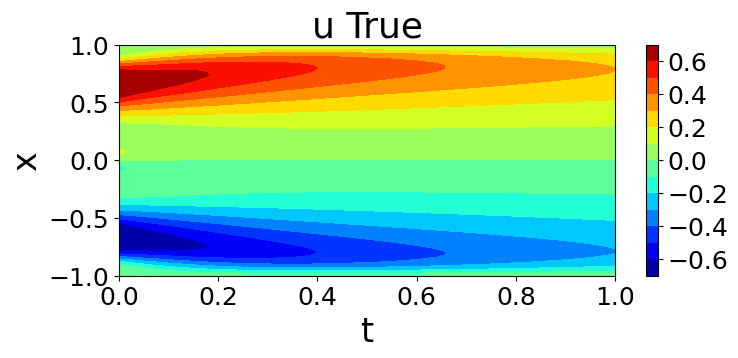

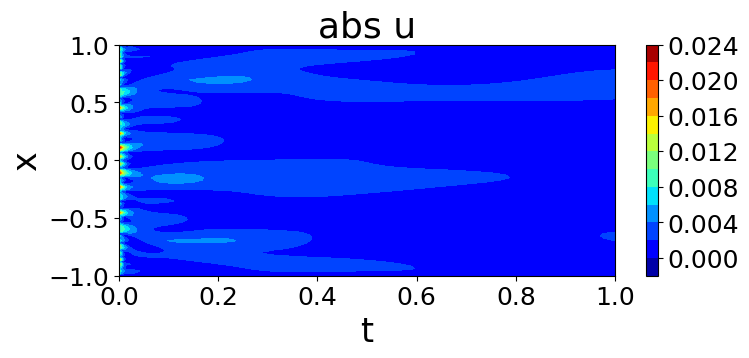

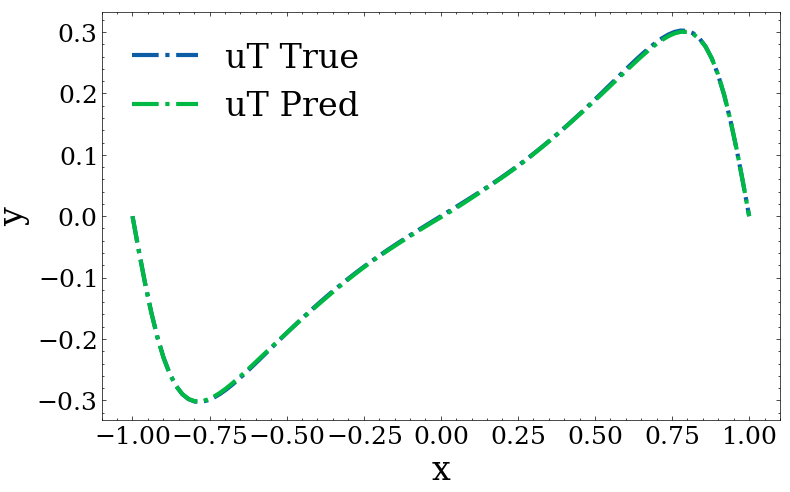

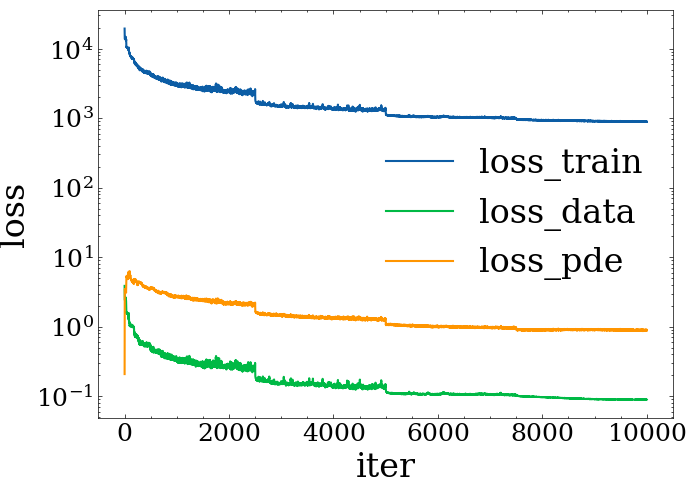

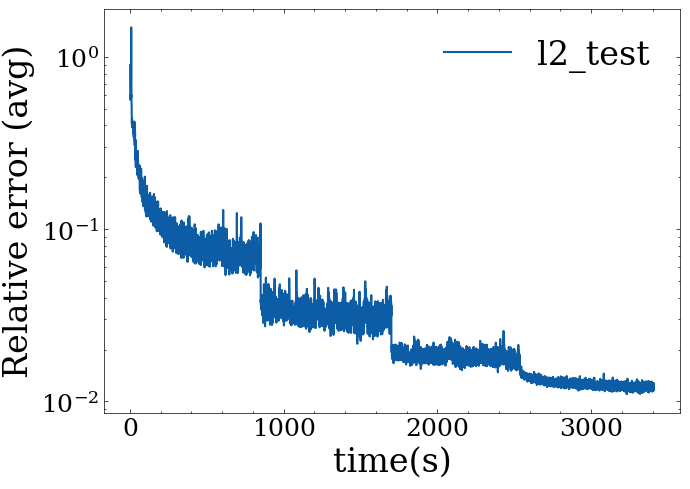

In [4]:
# #####################################
# # Load the trained model
# #####################################
from Solvers.PIDeepONet import PIDeepONet
solver = PIDeepONet.Solver(device=device, dtype=dtype)
tag = 'tanhBeta64'
model_trained = solver.loadModel(path=f'saved_models/PI{netType}_{tag}/', name=f'model_pideeponet_final')
########################################
xt_test = gridxt_test.repeat(u_test.shape[0], 1, 1).to(device)
u_pred = model_trained['u'](xt_test, a_test.to(device))
u_pred = mollifer()(u_pred, xt_test).detach().cpu()
#########################################
xt_end_test = xt_end.repeat(uT_test.shape[0], 1, 1).to(device)
uT_pred = model_trained['u'](xt_end_test, a_test.to(device))
uT_pred = mollifer()(uT_pred, xt_end_test).detach().cpu()
#
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of u_pred:', u_pred.shape)
print('The test loss (avg):', solver.getLoss(u_pred, u_test))
print('The test l2 error (avg):', solver.getError(u_pred, u_test))
#
inx = 5
# # # ########################################
from Utils.PlotFigure import Plot
Plot.show_1dt(gridxt_test, u_pred[inx], title='u True', tT=1.)
Plot.show_1dt(gridxt_test, torch.abs(u_pred[inx]-u_test[inx]), title='abs u', tT=1.)
Plot.show_1d_list(x_test[inx], [uT_test[inx], uT_pred[inx]], ['uT True', 'uT Pred'], lb=-1.)
# #############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/PI{netType}_{tag}/', name='loss_pideeponet')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])